<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76619 entries, 2006-12-16 17:24:00 to 2007-02-07 22:22:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    76613 non-null  float64
 1   Global_reactive_power  76613 non-null  float64
 2   Voltage                76613 non-null  float64
 3   Global_intensity       76613 non-null  float64
 4   Sub_metering_1         76613 non-null  float64
 5   Sub_metering_2         76613 non-null  float64
 6   Sub_metering_3         76613 non-null  float64
dtypes: float64(7)
memory usage: 4.7 MB
None
       Global_active_power  Global_reactive_power       Voltage  \
count         76613.000000           76613.000000  76613.000000   
mean              1.658787               0.130439    240.985307   
std               1.342300               0.118816      3.554508   
min               0.194000               0.000000    224.680000   
25%      

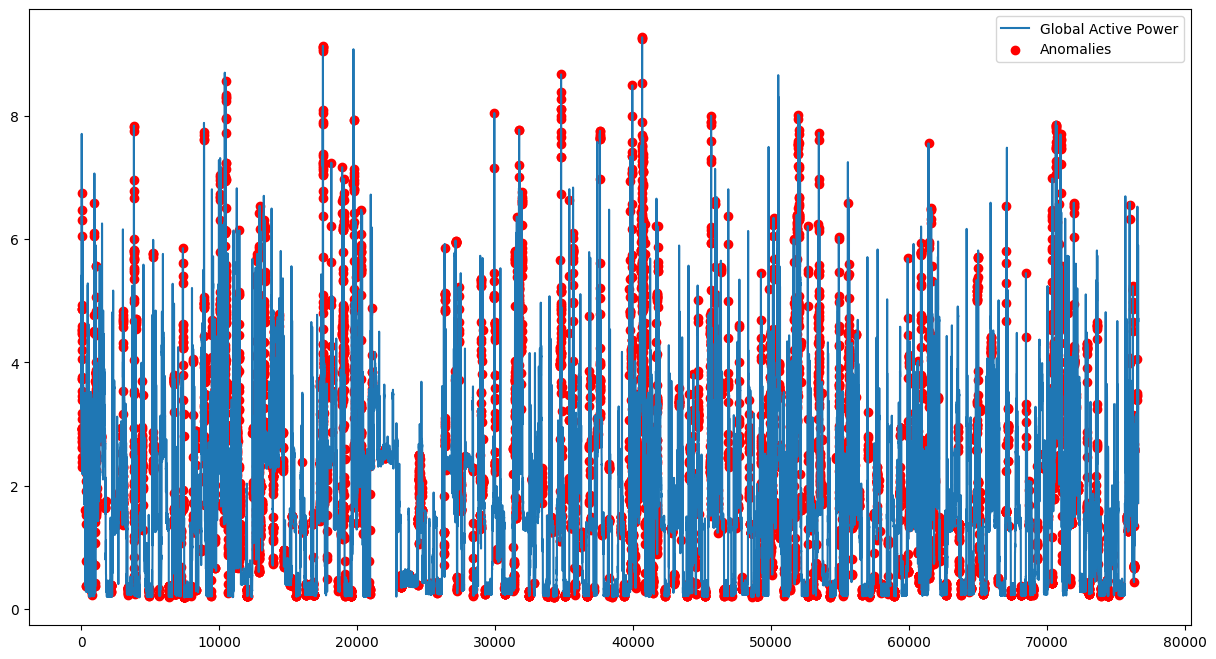

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
SEQ_LENGTH = 30
HIDDEN_DIM = 64
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

# Load the dataset
file_path = "/content/household_power_consumption.csv"  # Update this to your file path
data = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')

# Data Analysis
print(data.info())  # Check for missing values and data types
print(data.describe())  # Summary statistics

# Visualize distributions
#plt.figure(figsize=(15, 8))
#sns.lineplot(data=data, x="datetime", y="Global_active_power")
#plt.title("Global Active Power Over Time")
#plt.show()

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill missing values (if any) with mean
data.fillna(data.mean(), inplace=True)

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Data after scaling:\n", scaled_data[:5])

# Dataset Class
class PowerConsumptionDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.seq_length], dtype=torch.float32)

# Create dataset and dataloader
dataset = PowerConsumptionDataset(scaled_data, SEQ_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define LSTM Autoencoder Model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        out, _ = self.decoder(hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2))
        return out

# Model Initialization
model = LSTMAutoencoder(input_dim=scaled_data.shape[1], hidden_dim=HIDDEN_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Function
def train_model(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Train the model
train_model(model, dataloader, criterion, optimizer, EPOCHS)

# Anomaly Detection
def detect_anomalies(model, data, threshold=0.01):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for i in range(len(data) - SEQ_LENGTH):
            sequence = torch.tensor(data[i:i + SEQ_LENGTH], dtype=torch.float32).unsqueeze(0).to(device)
            reconstruction = model(sequence)
            loss = criterion(reconstruction, sequence).item()
            if loss > threshold:
                anomalies.append(i + SEQ_LENGTH)
    return anomalies

# Set anomaly detection threshold based on training loss
threshold = 0.01  # Adjust based on your analysis

# Detect anomalies
anomalies = detect_anomalies(model, scaled_data, threshold)

# Visualize anomalies
plt.figure(figsize=(15, 8))
plt.plot(data['Global_active_power'].values, label='Global Active Power')
plt.scatter(anomalies, data['Global_active_power'].values[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()


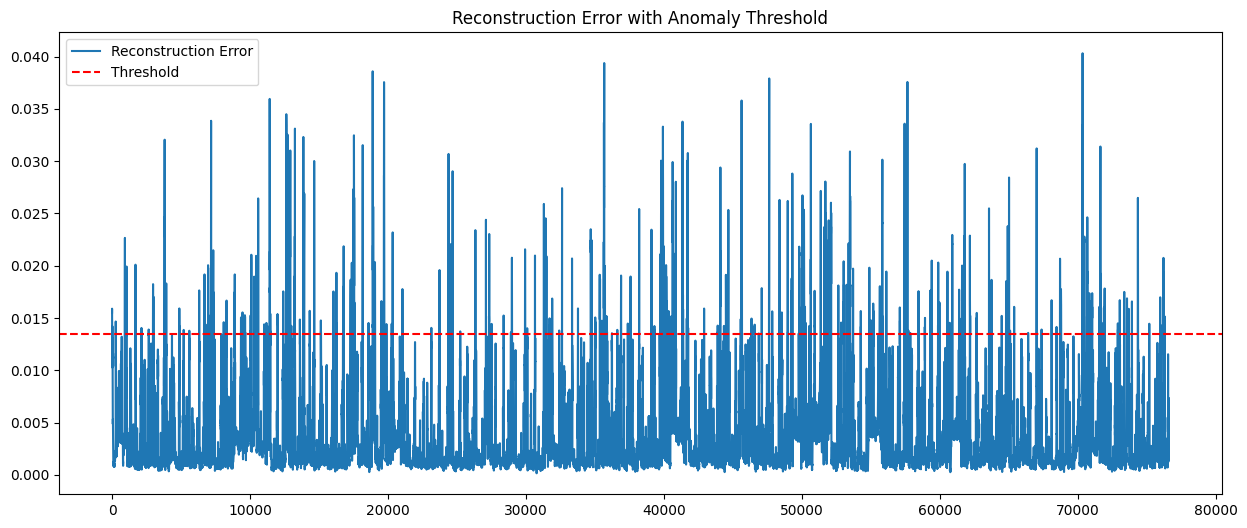

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming we have true labels for anomalies in `true_labels`
# true_labels: 1 for anomaly, 0 for normal
# If you don't have labels, this part can be skipped

def calculate_threshold(data, model, percentile=95):
    # Calculate reconstruction error for each sequence
    errors = []
    with torch.no_grad():
        for i in range(len(data) - SEQ_LENGTH):
            sequence = torch.tensor(data[i:i + SEQ_LENGTH], dtype=torch.float32).unsqueeze(0).to(device)
            reconstruction = model(sequence)
            loss = criterion(reconstruction, sequence).item()
            errors.append(loss)
    # Set threshold based on percentile of errors
    threshold = np.percentile(errors, percentile)
    return threshold, errors

# Set threshold based on 95th percentile of reconstruction errors
threshold, errors = calculate_threshold(scaled_data, model, percentile=95)

# Detect anomalies based on this threshold
anomaly_predictions = np.array([1 if error > threshold else 0 for error in errors])

# If you have true_labels, uncomment the following lines
# Replace true_labels with actual labeled data if available
# true_labels = [...]

# Evaluate with precision, recall, F1-score
# if 'true_labels' is available, otherwise skip this step
if 'true_labels' in locals():
    precision = precision_score(true_labels, anomaly_predictions)
    recall = recall_score(true_labels, anomaly_predictions)
    f1 = f1_score(true_labels, anomaly_predictions)
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

# Plotting Reconstruction Errors and Threshold
plt.figure(figsize=(15, 6))
plt.plot(errors, label="Reconstruction Error")
plt.axhline(y=threshold, color="r", linestyle="--", label="Threshold")
plt.legend()
plt.title("Reconstruction Error with Anomaly Threshold")
plt.show()

# Optional: Display anomaly detection accuracy if labels are present
if 'true_labels' in locals():
    accuracy = np.mean(anomaly_predictions == true_labels)
    print(f"Anomaly Detection Accuracy: {accuracy:.2f}")


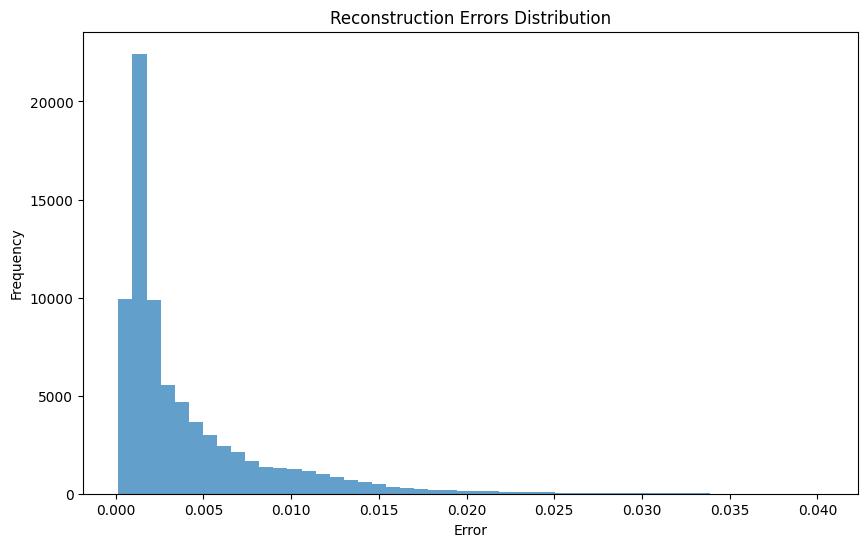

In [4]:
# Calculate reconstruction errors
reconstruction_errors = []
with torch.no_grad():
    for i in range(len(scaled_data) - SEQ_LENGTH):
        sequence = torch.tensor(scaled_data[i:i + SEQ_LENGTH], dtype=torch.float32).unsqueeze(0).to(device)
        reconstruction = model(sequence)
        error = criterion(reconstruction, sequence).item()
        reconstruction_errors.append(error)

# Visualize reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7)
plt.title("Reconstruction Errors Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


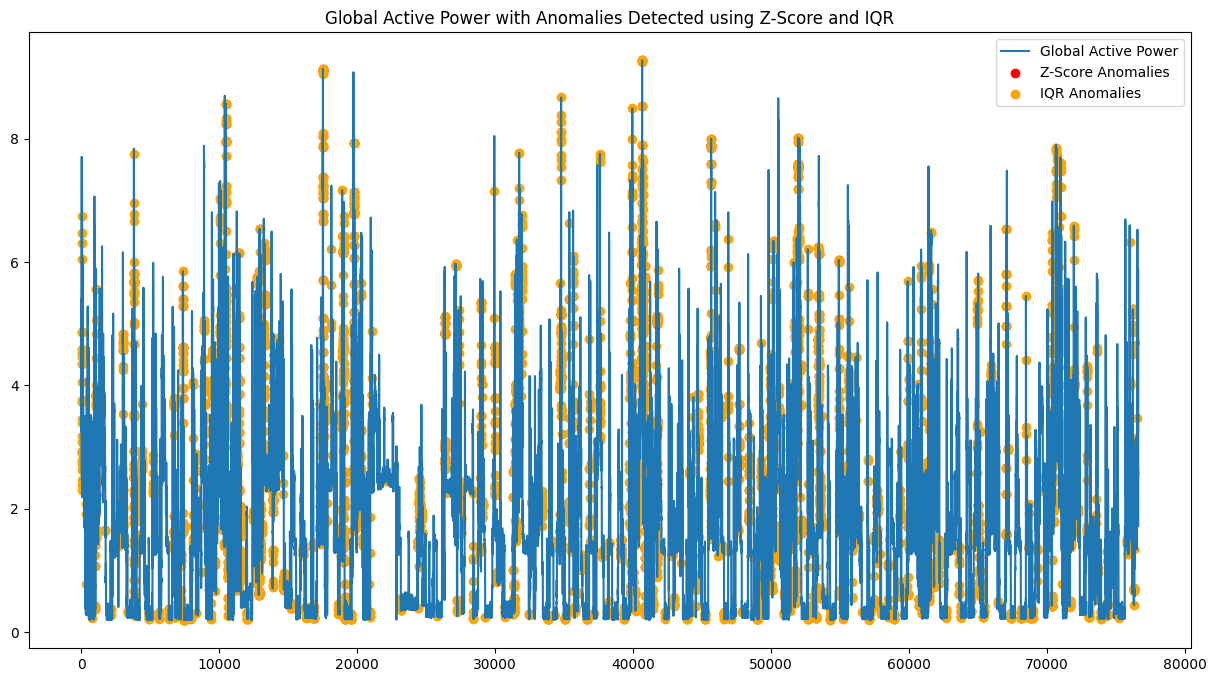

In [6]:
# Calculate reconstruction errors
reconstruction_errors = []
with torch.no_grad():
    for i in range(len(scaled_data) - SEQ_LENGTH):
        sequence = torch.tensor(scaled_data[i:i + SEQ_LENGTH], dtype=torch.float32).unsqueeze(0).to(device)
        reconstruction = model(sequence)
        error = criterion(reconstruction, sequence).item()  # Compute MSE loss
        reconstruction_errors.append(error)

# Convert to numpy array for easier handling
reconstruction_errors = np.array(reconstruction_errors)

# Z-Score Method
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)
z_scores = (reconstruction_errors - mean_error) / std_error
z_threshold = 3  # Threshold for anomaly detection based on Z-score

z_anomalies = np.where(np.abs(z_scores) > z_threshold)[0]

# IQR Method
Q1 = np.percentile(reconstruction_errors, 25)
Q3 = np.percentile(reconstruction_errors, 75)
IQR = Q3 - Q1
iqr_threshold_low = Q1 - 1.5 * IQR
iqr_threshold_high = Q3 + 1.5 * IQR

iqr_anomalies = np.where((reconstruction_errors < iqr_threshold_low) | (reconstruction_errors > iqr_threshold_high))[0]

# Visualize anomalies detected using Z-Score and IQR
plt.figure(figsize=(15, 8))
plt.plot(data['Global_active_power'].values, label='Global Active Power')
plt.scatter(z_anomalies + SEQ_LENGTH, data['Global_active_power'].values[z_anomalies + SEQ_LENGTH], color='red', label='Z-Score Anomalies')
plt.scatter(iqr_anomalies + SEQ_LENGTH, data['Global_active_power'].values[iqr_anomalies + SEQ_LENGTH], color='orange', label='IQR Anomalies')
plt.legend()
plt.title('Global Active Power with Anomalies Detected using Z-Score and IQR')
plt.show()
